In [1]:
import os
import importlib
import glob
import pickle
import tqdm
import functools
import multiprocessing
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import util_figures
import util_localization_psychophysics
import util_localization_psychophysics_figures
import util_spkr_word_psychophysics
import util_spkr_word_psychophysics_figures
import util


def map_tag_model_to_x(tag_model):
    """
    Maps model names to phase locking limit values
    """
    if "IHC3000" in tag_model:
        return 3000
    elif "IHC1000" in tag_model:
        return 1000
    elif "IHC0320" in tag_model:
        return 320
    elif "IHC0050" in tag_model:
        return 50
    else:
        raise ValueError(f"Did not recognize {tag_model=}")


Loaded: data/model/sound_localization.pkl
Loaded: data/model/sound_localization_human_model_comparison_metrics.pkl


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

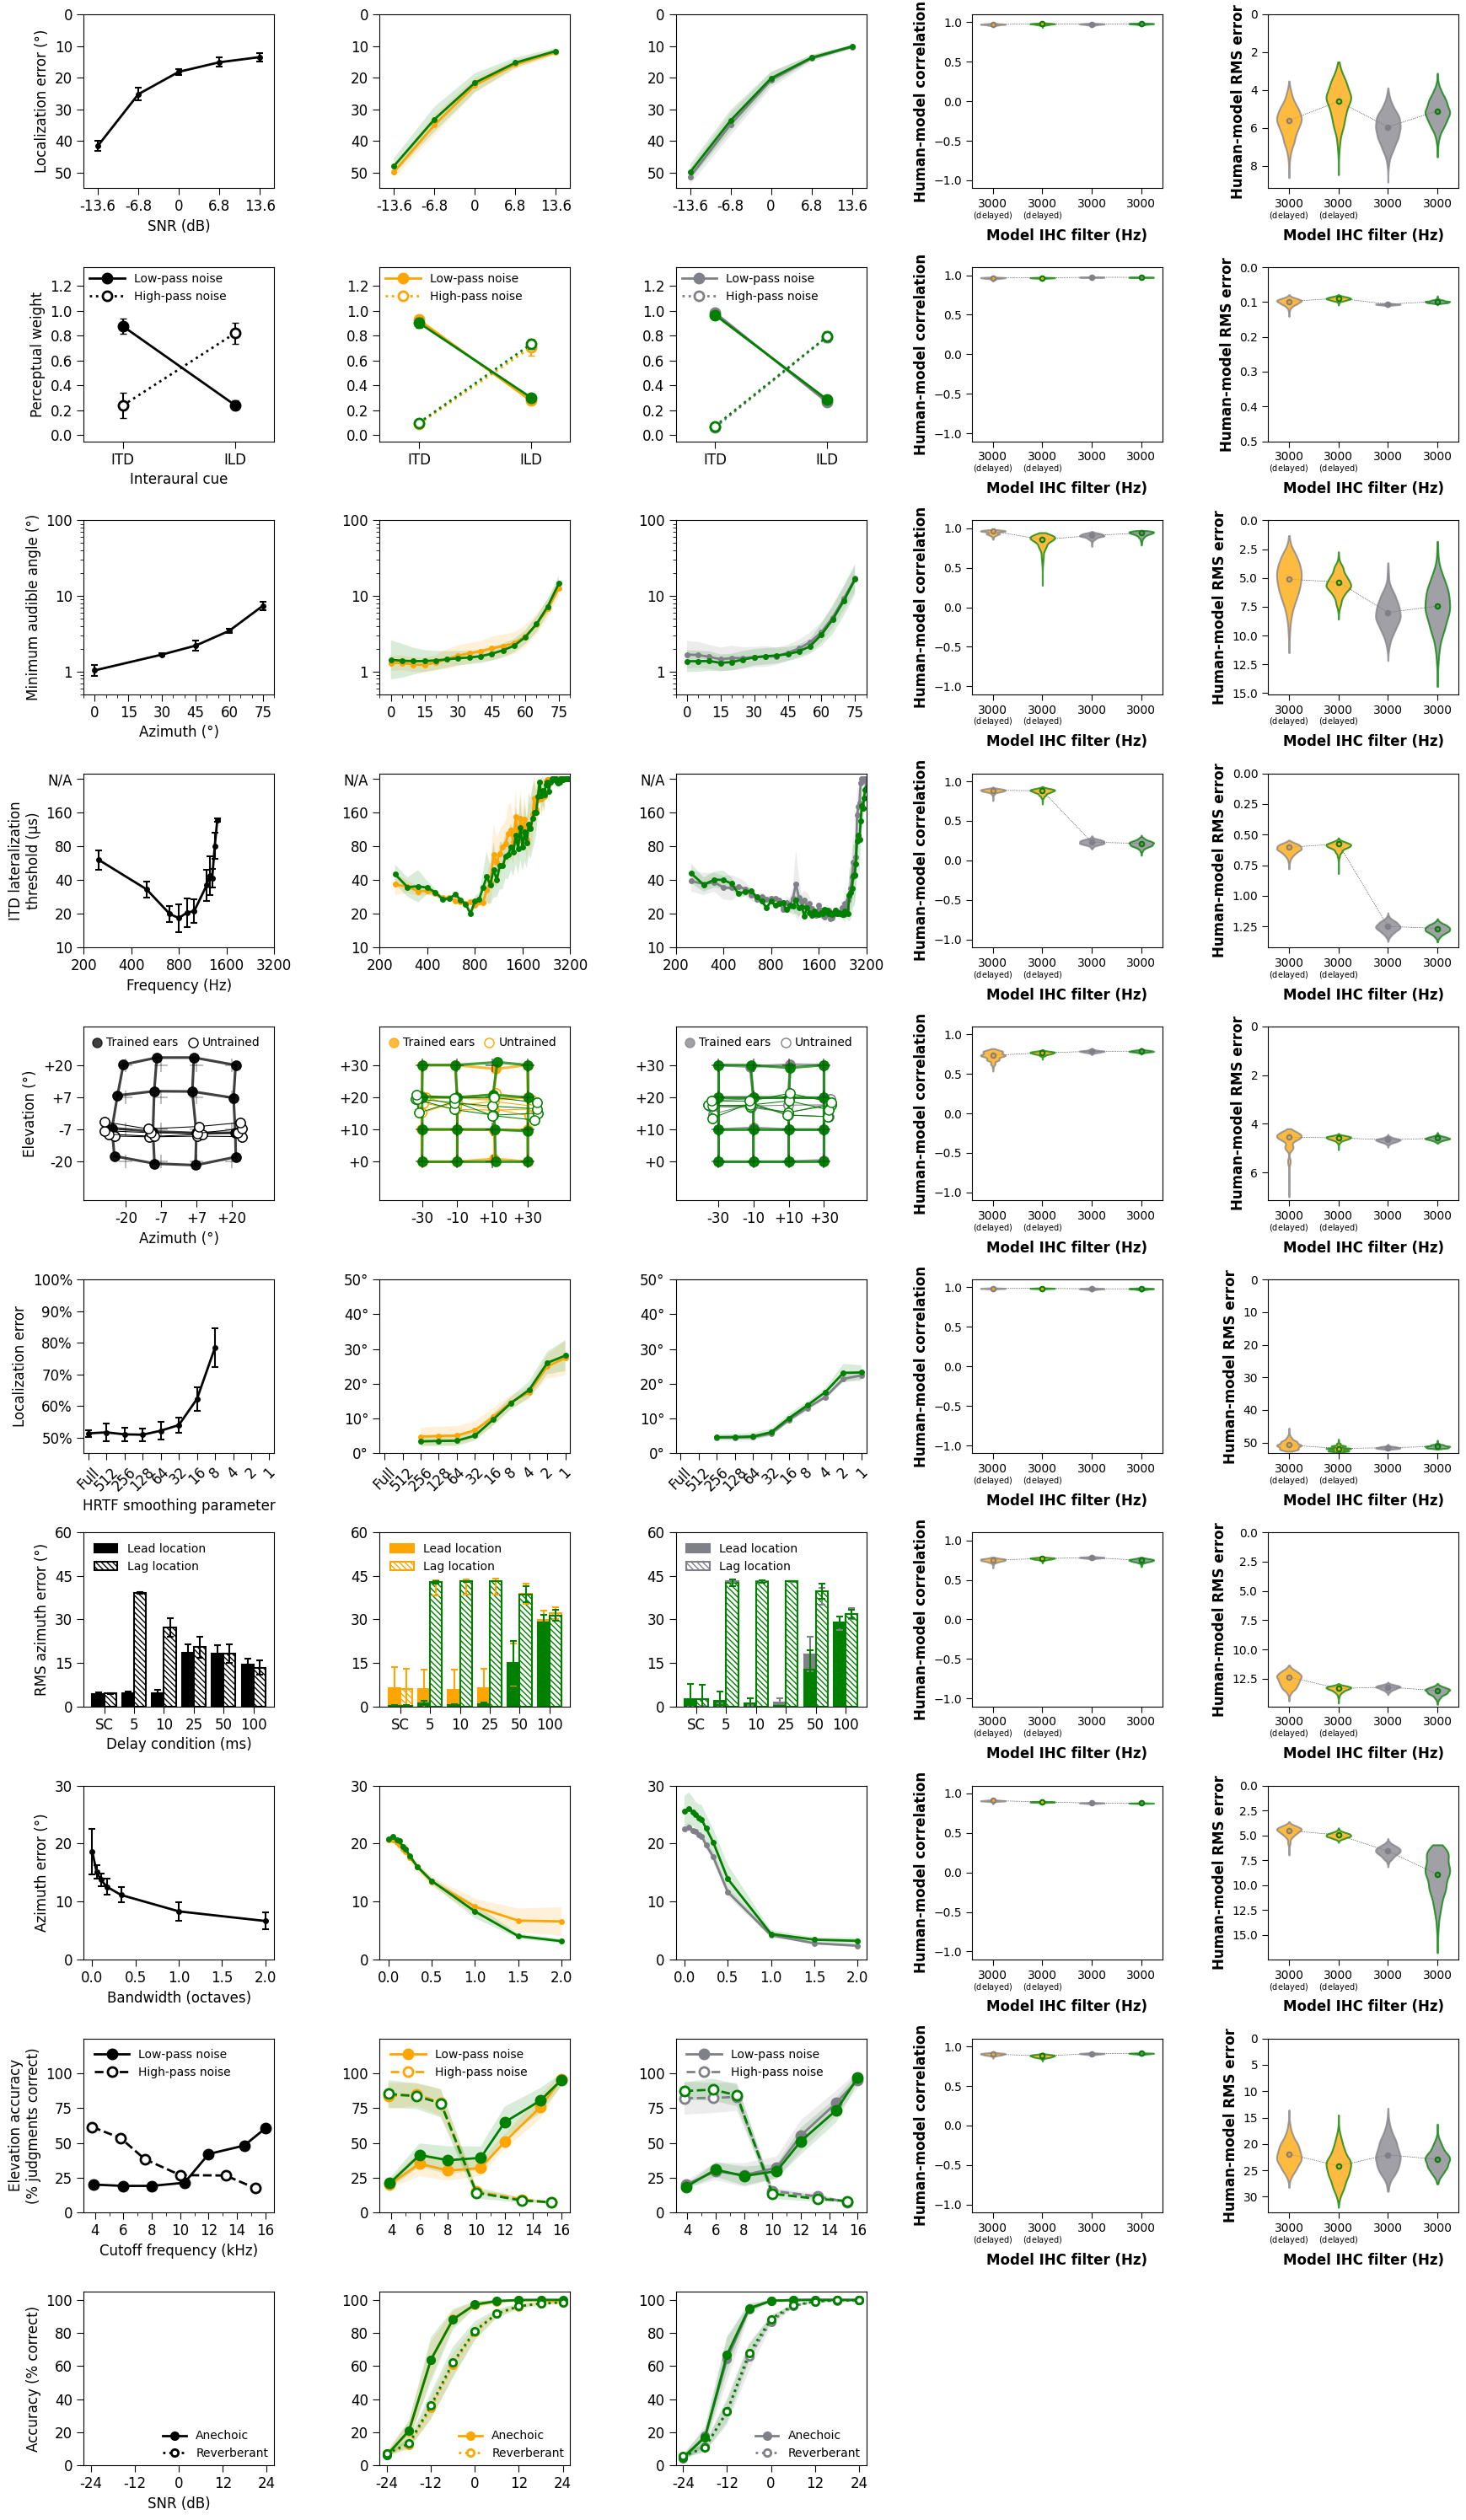

In [3]:
fn_data = "data/model/sound_localization.pkl"
fn_metrics = "data/model/sound_localization_human_model_comparison_metrics.pkl"

list_tag_model = [
    "human",
    "models/sound_localization/IHC3000_delayed_integration/arch??",
    "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
    "models/sound_localization/IHC3000/arch??",
    "models/sound_localization/sr20000_IHC3000/arch??",
]

with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
df_comparison = pd.read_pickle(fn_metrics)
print(f"Loaded: {fn_metrics}")

map_tag_expt_to_plot_func = {
    "snr_dependency": util_localization_psychophysics_figures.make_plot_snr_dependency,
    "itd_ild_weighting": util_localization_psychophysics_figures.make_plot_itd_ild_weighting,
    "maa_azimuth": util_localization_psychophysics_figures.make_plot_maa_azimuth,
    "itd_threshold": util_localization_psychophysics_figures.make_plot_itd_threshold,
    "new_ears": util_localization_psychophysics_figures.make_plot_new_ears,
    "spectral_smoothing": util_localization_psychophysics_figures.make_plot_spectral_smoothing,
    "precedence_effect_localization": util_localization_psychophysics_figures.make_plot_precedence_effect_localization,
    "bandwidth_dependency": util_localization_psychophysics_figures.make_plot_bandwidth_dependency,
    "mp_spectral_cues": util_localization_psychophysics_figures.make_plot_mp_spectral_cues,
    "speech_in_noise_in_reverb": util_localization_psychophysics_figures.make_plot_speech_in_noise_in_reverb,
}

list_key_metric = [
    "pearsonr",
    "rmse",
]
nrows = len(map_tag_expt_to_plot_func.keys())
ncols = len(list_tag_model) - 2 + len(list_key_metric)
figsize = (3.5 * ncols, 3 * nrows)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax_arr = ax_arr.reshape([nrows, ncols])
for c, tag_model in enumerate(list_tag_model):
    for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
        column = c
        if "IHC" in tag_model:
            column = 1 if "delayed" in tag_model else 2
        ax = ax_arr[r, column]
        df = EXPERIMENT_DATAFRAMES[tag_expt]
        color, _ = util.get_color_and_label_from_model_tag(tag_model)
        if "delayed" in tag_model:
            color = "orange"
        if "sr20000" in tag_model:
            color = "green"
        map_tag_expt_to_plot_func[tag_expt](
            ax,
            df[df.tag_model == tag_model],
            color=color,
            include_legend="sr20000" not in tag_model,
        )
        if c > 0:
            ax.xaxis.label.set_color("w")
            ax.yaxis.label.set_color("w")

for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    for itr_metric, key_metric in enumerate(list_key_metric):
        c = len(list_tag_model) - 2 + itr_metric
        ax = ax_arr[r, c]
        kwargs_format_axes_update = {
            "fontsize_ticks": 10,
            "fontweight_labels": "bold",
            "str_ylabel": r"Human-model correlation" if key_metric == "pearsonr" else "Human-model RMS error",
            "str_xlabel": "Model IHC filter (Hz)",
        }
        if key_metric == "pearsonr":
            kwargs_format_axes_update["ylimits"] = [-1.1, 1.1]
            kwargs_format_axes_update["yticks"] = [-1, -0.5, 0, 0.5, 1]
        if key_metric == "rmse":
            kwargs_format_axes_update["ylimits"] = [0, None]
        if len(df_comparison[df_comparison.tag_expt == tag_expt]) > 0:
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df_comparison[df_comparison.tag_expt == tag_expt],
                key_metric=key_metric,
                list_tag_model=list_tag_model[1:],
                kwargs_format_axes_update=kwargs_format_axes_update)
            if not key_metric == "pearsonr":
                ax.invert_yaxis()
            ylim = list(ax.get_ylim())
            if (key_metric == "rmse") and (ylim[0] < 0.5):
                ylim[0] = 0.5
                ax.set_ylim(ylim)
        else:
            ax.set_axis_off()
plt.tight_layout()
plt.show()


Loaded: data/model/spkr_word_recognition.pkl
Loaded: data/model/spkr_word_recognition_human_model_comparison_metrics.pkl


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


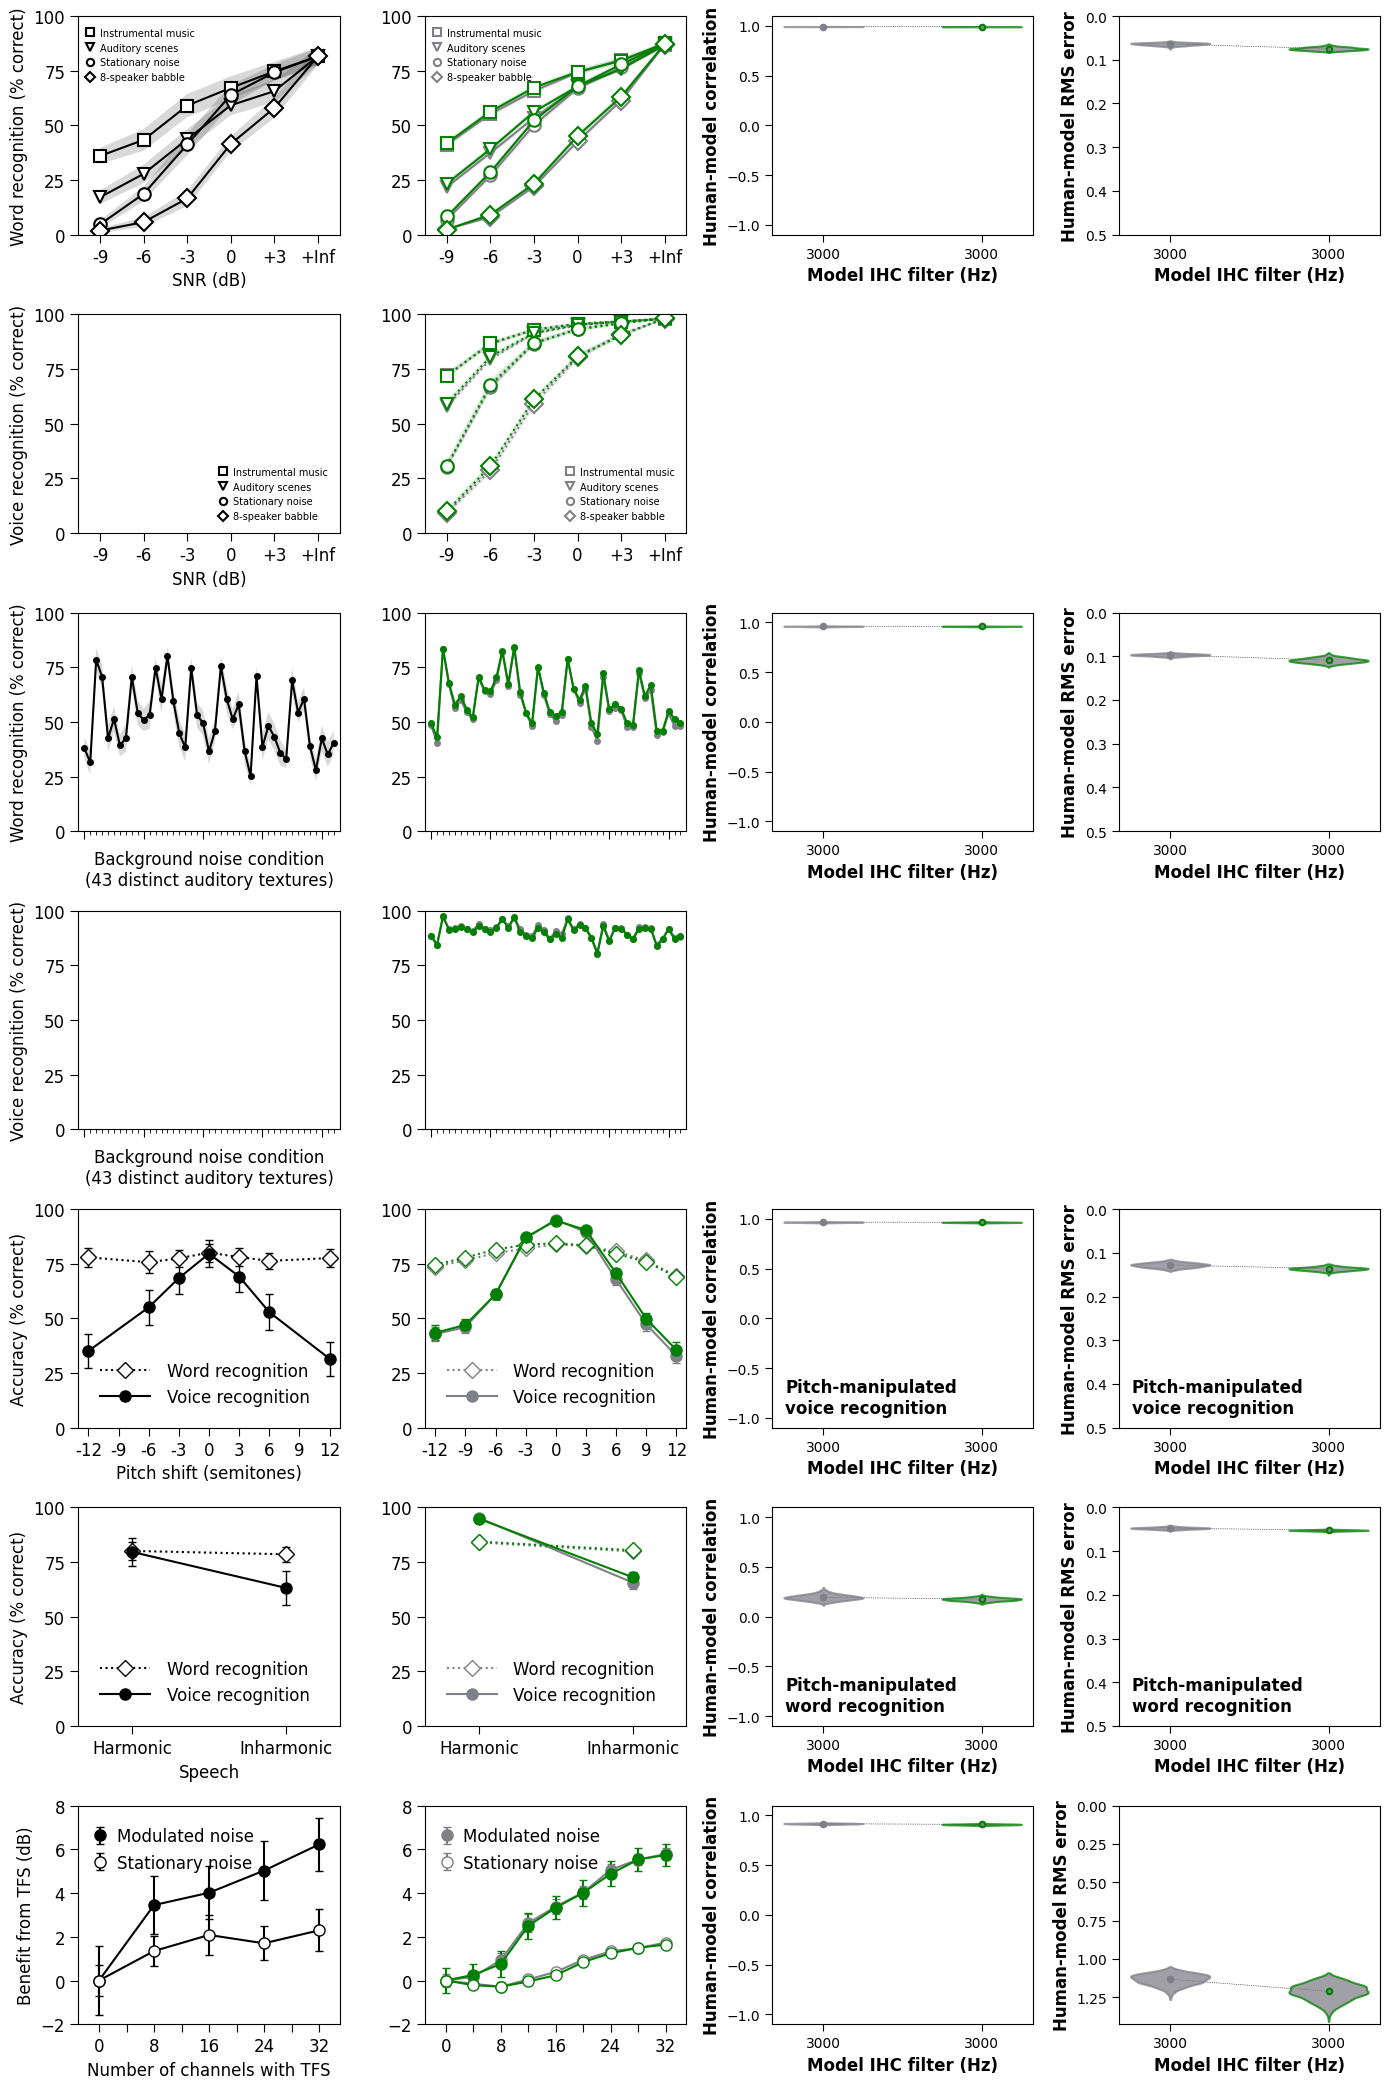

In [3]:
fn_data = "data/model/spkr_word_recognition.pkl"
fn_metrics = "data/model/spkr_word_recognition_human_model_comparison_metrics.pkl"

list_tag_model = [
    "human",
    "models/spkr_word_recognition/IHC3000/arch0_00??",
    "models/spkr_word_recognition/sr20000_IHC3000/arch0_00??",
]
SINGLE_TASK_MODELS = 0 # Set to 1 to automatically replace joint word/voice recognition models with single-task variants

with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
df_comparison = pd.read_pickle(fn_metrics)
print(f"Loaded: {fn_metrics}")

map_tag_expt_to_plot_func = {
    "kell_like_word": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task="word",
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1]),
    "kell_like_spkr": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task="spkr",
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1],
        kwargs_plot_update={"ls": ":"}),
    "speech_in_synthetic_textures_word": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures,
        key_task="word"),
    "speech_in_synthetic_textures_spkr": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures,
        key_task="spkr"),
    "pitch_shifted": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_shifted_recognition,
        key_task=["word", "spkr"]),
    "pitch_condition": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_condition_recognition,
        key_task=["word", "spkr"]),
    "hopkins_moore_2009_word": util_spkr_word_psychophysics_figures.make_plot_hopkins_moore_2009_tfs_benefit,
}

list_key_metric = [
    "pearsonr",
    "rmse",
]
nrows = len(map_tag_expt_to_plot_func.keys())
ncols = len(list_tag_model) - 1 + len(list_key_metric)
figsize = (3.5 * ncols, 3 * nrows)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax_arr = ax_arr.reshape([nrows, ncols])
for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    tag_expt_for_dataframe = tag_expt
    if "pitch" in tag_expt:
        tag_expt_for_dataframe = "pitch_altered"
    for suffix in ["_spkr", "_word", "_dip_listening"]:
        tag_expt_for_dataframe = tag_expt_for_dataframe.replace(suffix, "")
    for c, tag_model in enumerate(list_tag_model):
        color, _ = util.get_color_and_label_from_model_tag(tag_model)
        include_legend = not "sr20000" in tag_model
        if not include_legend:
            color = "green"
        ax = ax_arr[r, c - 1 if "sr20000" in tag_model else c]
        df = EXPERIMENT_DATAFRAMES[tag_expt_for_dataframe]
        if (not tag_model == "human") and (SINGLE_TASK_MODELS):
            if "spkr" in tag_expt:
                df = df[df.tag_model == tag_model.replace("spkr_word_recognition", "spkr_recognition")]
                map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, key_task="spkr", include_legend=include_legend)
            if "word" in tag_expt:
                df = df[df.tag_model == tag_model.replace("spkr_word_recognition", "word_recognition")]
                map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, key_task="word", include_legend=include_legend)
            if (not "spkr" in tag_expt) and (not "word" in tag_expt):
                df_merged = df[df.tag_model == tag_model.replace("spkr_word_recognition", "spkr_recognition")].copy()
                df_word = df[df.tag_model == tag_model.replace("spkr_word_recognition", "word_recognition")].copy()
                for column in df_word.columns:
                    if "word" in column:
                        df_merged.loc[:, column] = df_word[column].values
                map_tag_expt_to_plot_func[tag_expt](ax, df_merged, color=color, include_legend=include_legend)
        else:
            df = df[df.tag_model == tag_model]
            map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, include_legend=include_legend)
        if c > 0:
            ax.xaxis.label.set_color("w")
            ax.yaxis.label.set_color("w")

for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    for itr_metric, key_metric in enumerate(list_key_metric):
        c = len(list_tag_model) - 1 + itr_metric
        ax = ax_arr[r, c]
        list_tag_model_for_make_plot_comparison_metrics = list_tag_model[1:]
        tag_expt_for_dataframe = tag_expt
        if "pitch_shifted" in tag_expt:
            tag_expt_for_dataframe = "pitch_altered_spkr"
        elif "pitch_condition" in tag_expt:
            tag_expt_for_dataframe = "pitch_altered_word"
        elif "speech_in_synthetic_textures_word" in tag_expt:
            tag_expt_for_dataframe = "speech_in_synthetic_textures"
        if SINGLE_TASK_MODELS:
            list_tag_model_for_make_plot_comparison_metrics = [
                _.replace(
                    "spkr_word_recognition",
                    "spkr_recognition" if "spkr" in tag_expt_for_dataframe else "word_recognition",
                )
                for _ in list_tag_model_for_make_plot_comparison_metrics
            ]
        kwargs_format_axes_update = {
            "fontsize_ticks": 10,
            "fontweight_labels": "bold",
            "str_ylabel": r"Human-model correlation" if key_metric == "pearsonr" else "Human-model RMS error",
            "str_xlabel": "Model IHC filter (Hz)",
        }
        if key_metric == "pearsonr":
            kwargs_format_axes_update["ylimits"] = [-1.1, 1.1]
            kwargs_format_axes_update["yticks"] = [-1, -0.5, 0, 0.5, 1]
        if key_metric == "rmse":
            kwargs_format_axes_update["ylimits"] = [0, None]
        if len(df_comparison[df_comparison.tag_expt == tag_expt_for_dataframe]) > 0:
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df_comparison[df_comparison.tag_expt == tag_expt_for_dataframe],
                key_metric=key_metric,
                list_tag_model=list_tag_model_for_make_plot_comparison_metrics,
                kwargs_format_axes_update=kwargs_format_axes_update)
            if not key_metric == "pearsonr":
                ax.invert_yaxis()
            kwargs_text = {"ha": "left", "va": "bottom", "transform": ax.transAxes, "fontsize":12, "fontweight": "bold"}
            if tag_expt_for_dataframe == "pitch_altered_word":
                ax.text(0.05, 0.05, "Pitch-manipulated\nword recognition", **kwargs_text)
            if tag_expt_for_dataframe == "pitch_altered_spkr":
                ax.text(0.05, 0.05, "Pitch-manipulated\nvoice recognition", **kwargs_text)
            ylim = list(ax.get_ylim())
            if (key_metric == "rmse") and (ylim[0] < 0.5):
                ylim[0] = 0.5
                ax.set_ylim(ylim)
        else:
            ax.set_axis_off()
plt.tight_layout()
plt.show()


In [4]:
# with open("data/model/sound_localization.pkl", "rb") as f:
#     EXPERIMENT_DATAFRAMES = pickle.load(f)

# map_k_to_tag_model = {
#     "human": "human",
#     "sr20000_3000_delayed": "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
#     "sr20000_3000": "models/sound_localization/sr20000_IHC3000/arch??",
#     "3000_delayed": "models/sound_localization/IHC3000_delayed_integration/arch??",
#     "3000": "models/sound_localization/IHC3000/arch??",
#     "1000": "models/sound_localization/IHC1000/arch??",
#     "320": "models/sound_localization/IHC0320/arch??",
#     "50": "models/sound_localization/IHC0050/arch??",
# }

# df_results = EXPERIMENT_DATAFRAMES["snr_dependency"]
# list_k_model = [
#     # "human",
#     "sr20000_3000_delayed",
#     "sr20000_3000",
#     "3000_delayed",
#     "3000",
#     "1000",
#     # "320",
#     # "50",
# ]
# dict_key_metric = {
#     "deg_err": {
#         "str_title": "Spherical error",
#         "ylimits": [60, 0],
#         "yticks": [60, 45, 30, 15, 0],
#     },
#     "deg_azim_err": {
#         "str_title": "Azimuth error",
#         "ylimits": [60, 0],
#         "yticks": [60, 45, 30, 15, 0],
#     },
#     "deg_elev_err": {
#         "str_title": "Elevation error",
#         "ylimits": [20, 0],
#         "yticks": [20, 15, 10, 5, 0],
#     },
# }
# nrows = 1
# ncols = len(dict_key_metric)
# fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8.5, 3.0))

# for itr_ax, key_metric in enumerate(dict_key_metric.keys()):
#     ax = ax_arr[itr_ax]
#     for itr_model, k_model in enumerate(list_k_model):
#         tag_model = map_k_to_tag_model[k_model]
#         # color, label = util.get_color_and_label_from_model_tag(tag_model)
#         label = k_model
#         color = util_figures.get_color_list(5)[itr_model]
#         dfi = df_results[np.logical_and.reduce([
#             df_results.tag_model == tag_model
#         ])]
#         if "pool" in tag_model:
#             color = "orange"
#             label = None
#         kwargs_format_axes_update = {
#             "fontweight_title": "bold",
#             "fontsize_ticks": 10,
#             "str_ylabel": "Mean absolute error (°)" if itr_ax == 0 else None,
#             "str_xlabel": "SNR (dB)" if itr_ax == 0 else None,
#         }
#         kwargs_format_axes_update.update(dict_key_metric[key_metric])
#         kwargs_plot_update = {
#             "color": color,
#             "label": label,
#         }
#         ax = util_localization_psychophysics_figures.make_plot_snr_dependency(
#             ax,
#             dfi,
#             key_metric=key_metric,
#             kwargs_plot_update=kwargs_plot_update,
#             kwargs_format_axes_update=kwargs_format_axes_update)
#     if itr_ax == 1:
#         kwargs_legend = {
#             "loc": "lower right",
#             "borderpad": 0.5,
#             "borderaxespad": 0,
#             "frameon": False,
#             "framealpha": 1.0,
#             "facecolor": "w",
#             "edgecolor": "k",
#             "handlelength": 0,
#             "markerscale": 2.0,
#             "fontsize": 8.5,
#         }
#         ax.legend(**kwargs_legend)
# plt.tight_layout()
# plt.show()


In [5]:
# list_tag_model = [
#     "sr20000_IHC3000_delayed_integration",
#     "sr20000_IHC3000",
#     "IHC3000_delayed_integration",
#     "IHC3000",
# ]
# fig, ax_arr = plt.subplots(
#     nrows=1,
#     ncols=len(list_tag_model),
#     figsize=(4 * len(list_tag_model), 4),
# )
# for itr_ax, tag_model in enumerate(list_tag_model):
#     list_dir_model = glob.glob(f"models/sound_localization/{tag_model}/arch??")
#     for dir_model in list_dir_model:
#         df = pd.read_csv(os.path.join(dir_model, "log_optimize.csv"))
#         ax_arr[itr_ax].plot(df.epoch, df.val_accuracy)
#     util_figures.format_axes(
#         ax_arr[itr_ax],
#         ylimits=[0, 0.4],
#         str_xlabel="epoch",
#         str_ylabel="valid_acc",
#         str_title=tag_model,
#     )
# plt.tight_layout()
# plt.show()



Comparing TASK `spkr` METRIC `pearsonr` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.7456, cohen_d=-0.4709 <==


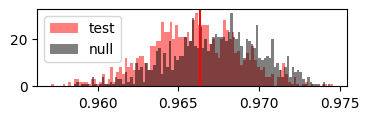


Comparing TASK `spkr` METRIC `correct_spkr` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.0627, cohen_d=1.4109 <== 75.26196808510637 75.71808510638297


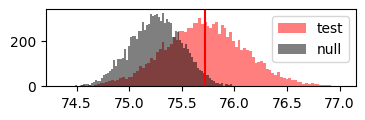


Comparing TASK `word` METRIC `pearsonr` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.2933, cohen_d=-1.3238 <==


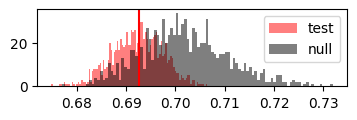


Comparing TASK `word` METRIC `correct_word` between:
|__ models/spkr_word_recognition/IHC3000/arch0_00?? (null)
|__ models/spkr_word_recognition/sr20000_IHC3000/arch0_00??
==> RESULT: p=0.0003, cohen_d=3.2444 <== 46.82845744680851 47.993351063829785


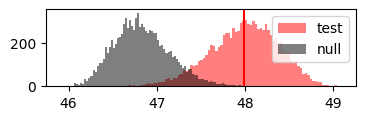

In [6]:
tag_model_ref = "models/spkr_word_recognition/IHC3000/arch0_00??"
tag_model_cmp = "models/spkr_word_recognition/sr20000_IHC3000/arch0_00??"

for key_task in ["spkr", "word"]:
    key_metric_comparison = "pearsonr"
    key_metric_performance = f"correct_{key_task}"
    
    df = pd.read_pickle("data/model/spkr_word_recognition_human_model_comparison_metrics.pkl")
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
        df.tag_expt.str.contains(key_task),
        ~df.tag_expt.str.contains("spkr_word"), # Removes comparisons of speaker + word task together
    ])]
    df = util.normalize_comparison_metrics(df)
    df = util.average_comparison_metrics(df)
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_comparison}"]
    p_val = util.get_p_val(y_null, y_test)
    print("\nComparing TASK `{}` METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <==".format(
        key_task,
        key_metric_comparison,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()
    
    
    with open("data/model/spkr_word_recognition.pkl", "rb") as f:
        df = pickle.load(f)["kell_like"]
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
        df.snr.isin([-9, -6, -3, 0, 3]),
        df.background_condition.isin([0, 1, 2, 3]),
    ])]
    df = df.groupby(["tag_model"]).agg({f"{key_metric_performance}_list": list}).reset_index()
    df[f"{key_metric_performance}_list"] = df[f"{key_metric_performance}_list"].map(lambda _: np.array(_).mean(axis=0))
    df[f"{key_metric_performance}_list"] = df[f"{key_metric_performance}_list"].map(lambda _: 100 * np.array(_))
    df[f"{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(lambda _: np.mean(_))
    df[f"bootstrap_list_{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(
        lambda _: np.random.choice(_, size=(10000, len(_))).mean(axis=1))
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_performance}"]
    y_ref = df[df.tag_model == tag_model_ref].iloc[0][f"{key_metric_performance}"]
    p_val = util.get_p_val(y_null, y_test)
    print("\nComparing TASK `{}` METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <== {} {}".format(
        key_task,
        key_metric_performance,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
        y_ref,
        y_test,
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()



Comparing METRIC `pearsonr` between:
|__ models/sound_localization/IHC3000/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000/arch??
==> RESULT: p=0.9994, cohen_d=-0.5150 <==


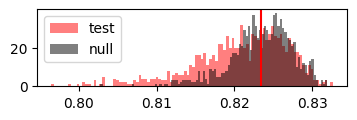


Comparing METRIC `deg_err` between:
|__ models/sound_localization/IHC3000/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000/arch??
==> RESULT: p=0.3986, cohen_d=-0.8835 <==


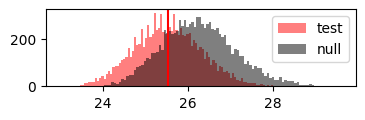


Comparing METRIC `pearsonr` between:
|__ models/sound_localization/IHC3000_delayed_integration/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000_delayed_integration/arch??
==> RESULT: p=0.3583, cohen_d=-1.1037 <==


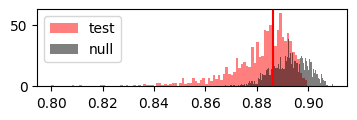


Comparing METRIC `deg_err` between:
|__ models/sound_localization/IHC3000_delayed_integration/arch?? (null)
|__ models/sound_localization/sr20000_IHC3000_delayed_integration/arch??
==> RESULT: p=0.1977, cohen_d=-1.1289 <==


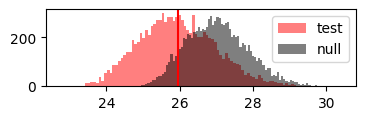

In [7]:
list_tag_pair = [
    ("models/sound_localization/IHC3000/arch??", "models/sound_localization/sr20000_IHC3000/arch??"),
    ("models/sound_localization/IHC3000_delayed_integration/arch??", "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??"),
]

for tag_model_ref, tag_model_cmp in list_tag_pair:
    key_metric_comparison = "pearsonr"
    key_metric_performance = "deg_err"

    df = pd.read_pickle("data/model/sound_localization_human_model_comparison_metrics.pkl")
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
    ])]
    df = util.normalize_comparison_metrics(df)
    df = util.average_comparison_metrics(df)
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_comparison}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_comparison}"]
    p_val = util.get_p_val(y_null, y_test)
    print("\nComparing METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <==".format(
        key_metric_comparison,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()


    with open("data/model/sound_localization.pkl", "rb") as f:
        df = pickle.load(f)["snr_dependency"]
    df = df[np.logical_and.reduce([
        df.tag_model.isin([tag_model_cmp, tag_model_ref]),
        np.isfinite(df.snr),
    ])]
    df = df.groupby(["tag_model"]).agg({f"{key_metric_performance}_list": list}).reset_index()
    df[f"{key_metric_performance}_list"] = df[f"{key_metric_performance}_list"].map(lambda _: np.array(_).mean(axis=0))
    df[f"{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(lambda _: np.mean(_))
    df[f"bootstrap_list_{key_metric_performance}"] = df[f"{key_metric_performance}_list"].map(
        lambda _: np.random.choice(_, size=(10000, len(_))).mean(axis=1))
    y_null = df[df.tag_model == tag_model_ref].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f"bootstrap_list_{key_metric_performance}"]
    y_test = df[df.tag_model == tag_model_cmp].iloc[0][f"{key_metric_performance}"]
    p_val = util.get_p_val(y_null, y_test)
    print("\nComparing METRIC `{}` between:\n|__ {} (null)\n|__ {}\n==> RESULT: p={:.4f}, cohen_d={:.4f} <==".format(
        key_metric_performance,
        tag_model_ref,
        tag_model_cmp,
        p_val,
        util.cohend(y_null, y_dist),
    ))
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.hist(y_dist, 100, alpha=0.5, color="r", label="test")
    ax.hist(y_null, 100, alpha=0.5, color="k", label="null")
    ax.axvline(y_test, color="r")
    ax.legend()
    plt.show()


['3000_simple_autocorr_input', '3000_simple_autocorr_concat', '3000_simple']


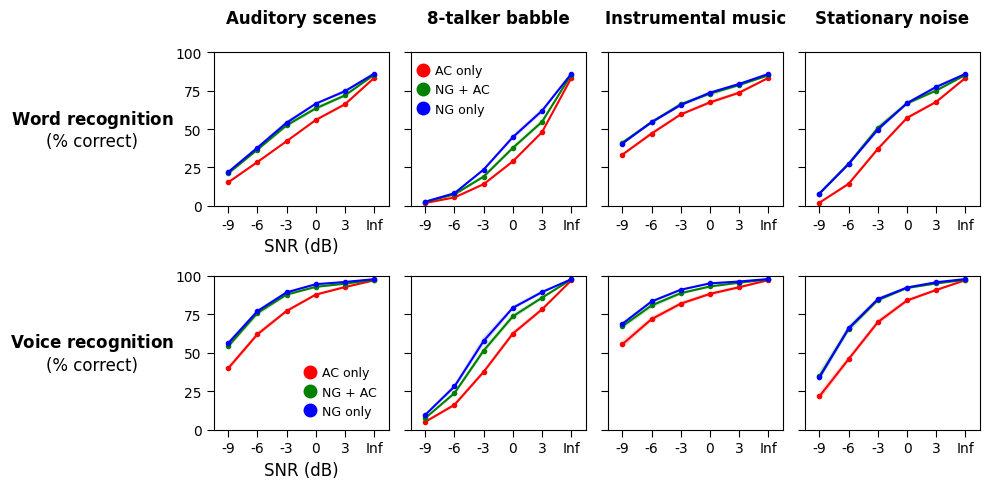

In [2]:
fn_data = "/om2/user/msaddler/phaselocknet/data/model/simplified_spkr_word_recognition.pkl"
with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)

map_k_to_tag_model = {
    "human": "human",
    "3000_simple": "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
    "1000_simple": "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
    "320_simple": "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
    "50_simple": "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
    "3000_simple_autocorr_concat": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC3000/arch0_00??",
    "1000_simple_autocorr_concat": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC1000/arch0_00??",
    "320_simple_autocorr_concat": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC0320/arch0_00??",
    "50_simple_autocorr_concat": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC0050/arch0_00??",
    "3000_simple_autocorr_input": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC3000/arch0_00??",
    "1000_simple_autocorr_input": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC1000/arch0_00??",
    "320_simple_autocorr_input": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0320/arch0_00??",
    "50_simple_autocorr_input": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_00??",

}

tag_expt = "kell_like"
df_results = EXPERIMENT_DATAFRAMES[tag_expt]
list_list_k_model = [
    # ["human", "3000_simple", "1000_simple", "320_simple", "50_simple"],
    # ["human", "3000_simple_autocorr_concat", "1000_simple_autocorr_concat", "320_simple_autocorr_concat", "50_simple_autocorr_concat"],
    # ["human", "3000_simple_autocorr_input", "1000_simple_autocorr_input", "320_simple_autocorr_input", "50_simple_autocorr_input"],
    ["3000_simple_autocorr_input", "3000_simple_autocorr_concat", "3000_simple"],
]
list_key_task = [
    "word",
    "spkr",
]
list_condition_title = [
    (0, "Auditory\nscenes"),
    (1, "8-talker\nbabble"),
    (2, "Instrumental\nmusic"),
    (3, "Stationary\nnoise"),
]
for list_k_model in list_list_k_model:
    print(list_k_model)
    fig, ax_arr = plt.subplots(
        nrows=len(list_key_task),
        ncols=4,
        figsize=(10, 2.5 * len(list_key_task)),
        sharey=True)
    for r, key_task in enumerate(list_key_task):
        for c, (condition, str_title) in enumerate(list_condition_title):
            ax = ax_arr[r, c]
            for k in list_k_model:
                tag_model = map_k_to_tag_model[k]
                color, label = util.get_color_and_label_from_model_tag(tag_model)
                if "input" in k:
                    color = "red"
                    label = "AC only"
                elif "concat" in k:
                    color = "green"
                    label = "NG + AC"
                else:
                    color = "blue"
                    label = "NG only"
                df = df_results[df_results.tag_model == tag_model]
                kwargs_plot_update = {
                    "marker": ".",
                    "ms": 6,
                    "mfc": color,
                    "mew": 1,
                    "lw": 1.5,
                    "label": label,
                }
                str_ylabel = "{} recognition\n(% correct)".format("Word" if key_task == "word" else "Voice")
                kwargs_format_axes_update = {
                    "str_ylabel": str_ylabel if c == 0 else None,
                    "str_xlabel": "SNR (dB)" if c == 0 else None,
                    "fontsize_ticks": 10,
                    "xticklabels": [-9, -6, -3, 0, 3, "Inf"],
                    "str_title": str_title.replace("\n", " ") + "\n" if r == 0 else None,
                    "fontweight_title": "bold"
                }
                kwargs_legend_update = {
                    "loc": "lower right",
                    "markerscale": 3,
                    "borderaxespad": 0.75,
                    "fontsize": 9,
                }
                include_legend = condition == 0
                if (key_task == "word") or ("inharmonic" in tag_expt):
                    include_legend = condition == 1
                    kwargs_legend_update["loc"] = "upper left"
                    kwargs_plot_update["label"] = label.replace(" IHC filter", "")
                if (k == "human") and (key_task == "spkr"):
                    pass
                else:
                    ax = util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition(
                        ax,
                        df,
                        key_task=key_task,
                        restrict_background_condition=[condition],
                        include_legend=include_legend,
                        color=color,
                        kwargs_plot_update=kwargs_plot_update,
                        kwargs_legend_update=kwargs_legend_update,
                        kwargs_format_axes_update=kwargs_format_axes_update,
                    )
            str_ylabel = "{}".format("Word" if key_task == "word" else "Voice")
            str_ylabel = r"$\bf{" + str_ylabel + "}$" + r" $\bf{recognition}$"
            str_ylabel += "\n(% correct)"
            ax_arr[r, 0].set_ylabel(str_ylabel, rotation=0, ha="center", va="center", labelpad=60)
    plt.tight_layout()
    plt.show()


['human', '3000_simple', '1000_simple', '320_simple', '50_simple']


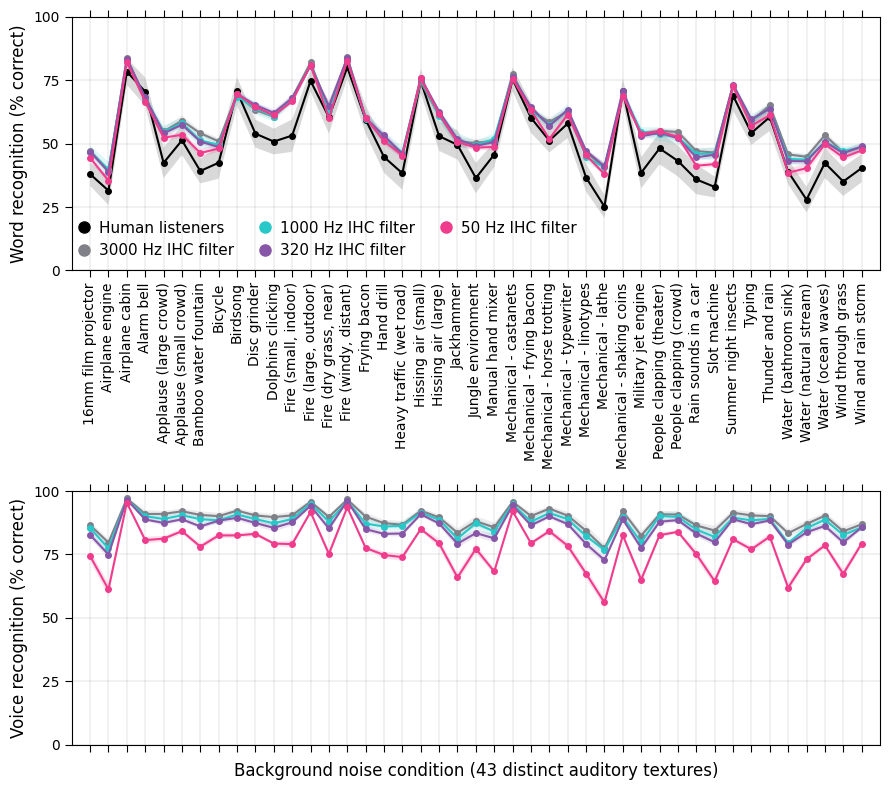

['human', '3000_simple_autocorr_concat', '1000_simple_autocorr_concat', '320_simple_autocorr_concat', '50_simple_autocorr_concat']


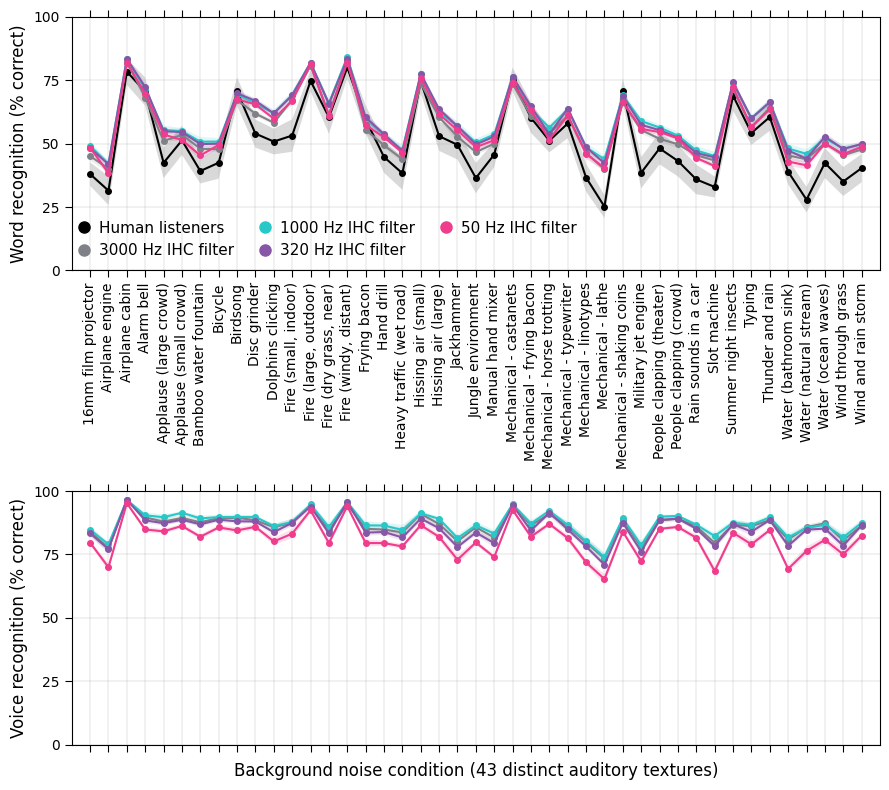

['human', '3000_simple_autocorr_input', '1000_simple_autocorr_input', '320_simple_autocorr_input', '50_simple_autocorr_input']


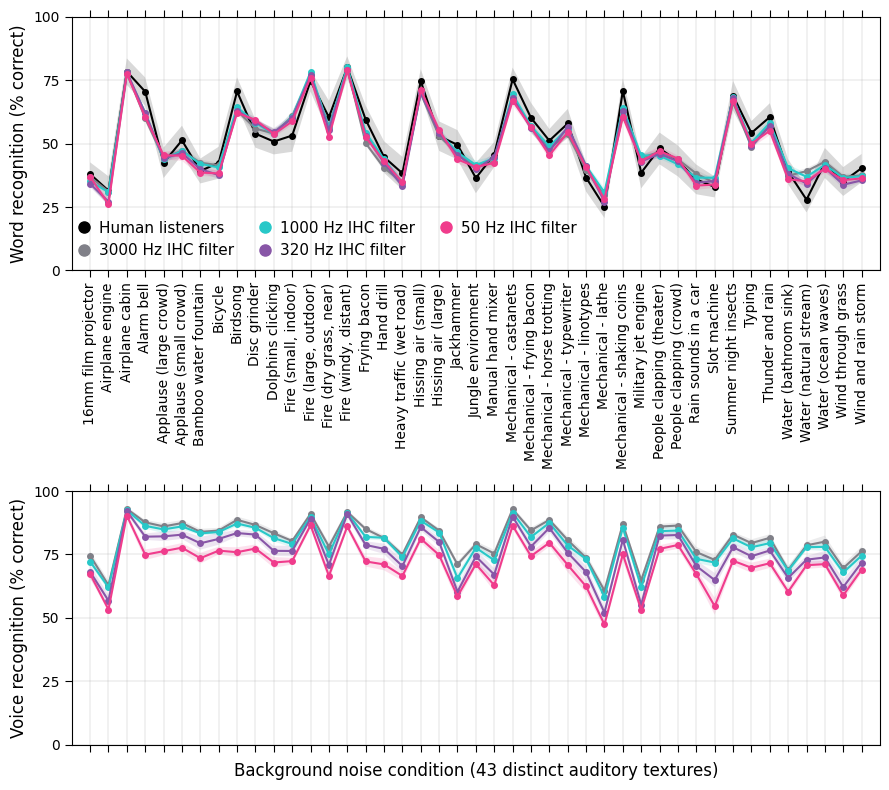

In [3]:
df_results = EXPERIMENT_DATAFRAMES["speech_in_synthetic_textures"]
list_list_k_model = [
    ["human", "3000_simple", "1000_simple", "320_simple", "50_simple"],
    ["human", "3000_simple_autocorr_concat", "1000_simple_autocorr_concat", "320_simple_autocorr_concat", "50_simple_autocorr_concat"],
    ["human", "3000_simple_autocorr_input", "1000_simple_autocorr_input", "320_simple_autocorr_input", "50_simple_autocorr_input"],
]
list_key_task = [
    "word",
    "spkr",
]
map_int_to_label = {
    0: "16mm film projector",
    1: "Airplane engine",
    2: "Airplane cabin",
    3: "Alarm bell",
    4: "Applause (large crowd)",
    5: "Applause (small crowd)",
    6: "Bamboo water fountain",
    7: "Bicycle",
    8: "Birdsong",
    9: "Disc grinder",
    10: "Dolphins clicking",
    11: "Fire (small, indoor)",
    12: "Fire (large, outdoor)",
    13: "Fire (dry grass, near)",
    14: "Fire (windy, distant)",
    15: "Frying bacon",
    16: "Hand drill",
    17: "Heavy traffic (wet road)",
    18: "Hissing air (small)",
    19: "Hissing air (large)",
    20: "Jackhammer",
    21: "Jungle environment",
    22: "Manual hand mixer",
    23: "Mechanical - castanets",
    24: "Mechanical - frying bacon",
    25: "Mechanical - horse trotting",
    26: "Mechanical - typewriter",
    27: "Mechanical - linotypes",
    28: "Mechanical - lathe",
    29: "Mechanical - shaking coins",
    30: "Military jet engine",
    31: "People clapping (theater)",
    32: "People clapping (crowd)",
    33: "Rain sounds in a car",
    34: "Slot machine",
    35: "Summer night insects",
    36: "Typing",
    37: "Thunder and rain",
    38: "Water (bathroom sink)",
    39: "Water (natural stream)",
    40: "Water (ocean waves)",
    41: "Wind through grass",
    42: "Wind and rain storm",
}
xticks = np.arange(len(map_int_to_label)).astype(int)
xticklabels = [map_int_to_label[_] for _ in xticks]
for list_k_model in list_list_k_model:
    print(list_k_model)
    fig, ax_arr = plt.subplots(nrows=len(list_key_task), ncols=1, figsize=(9, 8))
    for itr_ax, key_task in enumerate(list_key_task):
        ax = ax_arr[itr_ax]
        for itr_model, k in enumerate(list_k_model):
            tag_model = map_k_to_tag_model[k]
            color, label = util.get_color_and_label_from_model_tag(tag_model)
            df = df_results[df_results.tag_model == tag_model]
            kwargs_plot_update = {
                "label": label,
            }
            kwargs_legend_update = {
                "fontsize": 11,
                "handlelength": 0,
                "markerscale": 2,
                "ncols": 3,
                "borderaxespad": 0.5,
                "loc": "lower left",
            }
            kwargs_format_axes_update = {
                "fontsize_ticks": 10,
                "xticks": xticks,
                "xticklabels": xticklabels if itr_ax == 0 else [],
                "str_xlabel": "Background noise condition (43 distinct auditory textures)" if itr_ax == 1 else None,
                "major_tick_params_kwargs_update": {"top": True},
            }
            if len(df) > 0:
                ax = util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures(
                    ax,
                    df,
                    key_task=key_task,
                    color=color,
                    kwargs_plot_update=kwargs_plot_update,
                    kwargs_legend_update=kwargs_legend_update,
                    kwargs_format_axes_update=kwargs_format_axes_update,
                    include_legend=key_task=="word")
        if itr_ax == 0:
            ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
        ax.grid(lw=0.25)
    plt.tight_layout()
    plt.show()


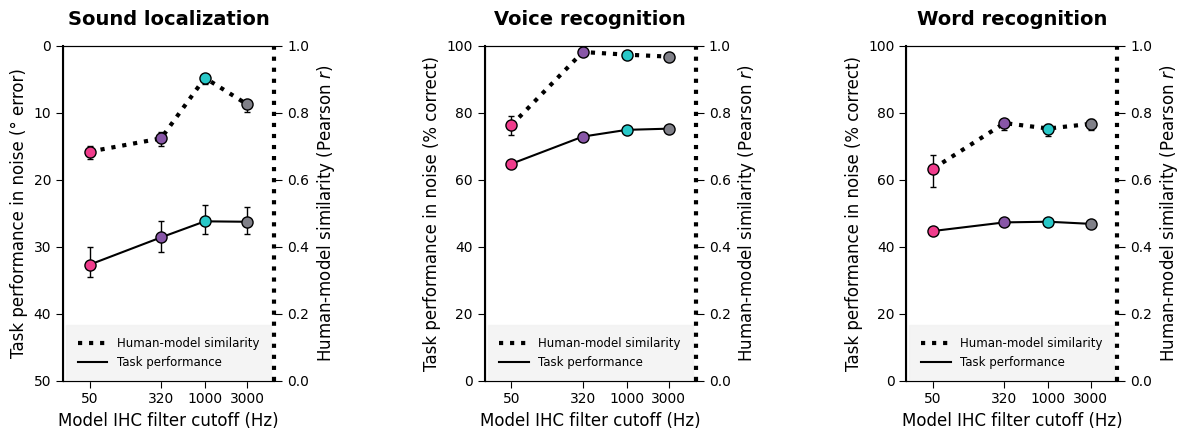

Comparing `performance` between `3000` and `3000_delayed`: p=0.4050, cohen_d=0.7829
Comparing `pearsonr` between `3000` and `3000_delayed`: p=0.0000, cohen_d=12.0122


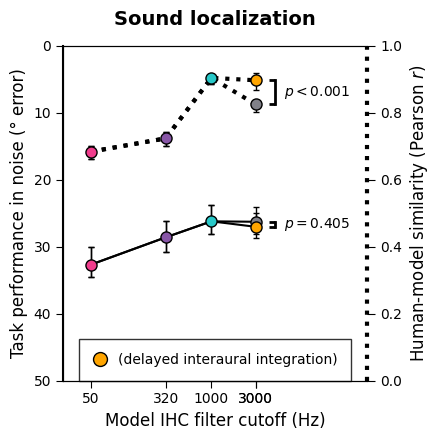

In [20]:
"""
Aggregate measures figures: plot overall task-performance and
human-model similarity as a function of phase locking limit
"""

dict_tag_model = {
    "localization": {
        "3000_delayed": "models/sound_localization/IHC3000_delayed_integration/arch??",
        "3000": "models/sound_localization/IHC3000/arch??",
        "1000": "models/sound_localization/IHC1000/arch??",
        "320": "models/sound_localization/IHC0320/arch??",
        "50": "models/sound_localization/IHC0050/arch??",
        "3000_delayed_simple": "models/sound_localization/simplified_IHC3000_delayed_integration/arch??",
        "3000_simple": "models/sound_localization/simplified_IHC3000/arch??",
        "1000_simple": "models/sound_localization/simplified_IHC1000/arch??",
        "320_simple": "models/sound_localization/simplified_IHC0320/arch??",
        "50_simple": "models/sound_localization/simplified_IHC0050/arch??",
    },
    "spkr": {
        "3000": "models/spkr_word_recognition/IHC3000/arch0_00??",
        "1000": "models/spkr_word_recognition/IHC1000/arch0_00??",
        "320": "models/spkr_word_recognition/IHC0320/arch0_00??",
        "50": "models/spkr_word_recognition/IHC0050/arch0_00??",
        "3000_simple": "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
        "1000_simple": "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
        "320_simple": "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
        "50_simple": "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
    },
    "word": {
        "3000": "models/spkr_word_recognition/IHC3000/arch0_00??",
        "1000": "models/spkr_word_recognition/IHC1000/arch0_00??",
        "320": "models/spkr_word_recognition/IHC0320/arch0_00??",
        "50": "models/spkr_word_recognition/IHC0050/arch0_00??",
        "3000_simple": "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
        "1000_simple": "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
        "320_simple": "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
        "50_simple": "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
    },
}


list_list_key_task = [
    ["localization", "spkr", "word"],
    ["localization"],
]
for list_key_task in list_list_key_task:
    list_k = [
        "50",
        "320",
        "1000",
        "3000",
    ]
    if len(list_key_task) == 1:
        list_k.append("3000_delayed")
    dict_key_metric0 ={
        "localization": "deg_err",
        "spkr": "correct_spkr",
        "word": "correct_word",
    }
    dict_key_metric1 ={
        "localization": "pearsonr",
        "spkr": "pearsonr",
        "word": "pearsonr",
    }
    ncols = len(list_key_task)
    fig, ax_arr = plt.subplots(nrows=1, ncols=ncols, figsize=(max(4 * ncols, 4.5), 4.5))
    ax_arr = np.array(ax_arr).reshape([ncols])
    for itr0, key_task in enumerate(list_key_task):
        ax0 = ax_arr[itr0]
        ax1 = ax0.twinx()
        for itr1, (ax, key_metric) in enumerate(zip([ax0, ax1], ["performance", "pearsonr"])):
            list_tag_model = [dict_tag_model[key_task].get(k, None) for k in list_k]
            list_tag_model = [_ for _ in list_tag_model if _ is not None]
            list_y, list_y_dist = util.get_aggregate_measure(
                fn_data_localization="data/model/sound_localization.pkl",
                fn_data_spkr_word="data/model/spkr_word_recognition.pkl",
                fn_comparison_localization="data/model/sound_localization_human_model_comparison_metrics.pkl",
                fn_comparison_spkr_word="data/model/spkr_word_recognition_human_model_comparison_metrics.pkl",
                list_tag_model=list_tag_model,
                key_task=key_task,
                key_metric=key_metric,
            )
            x = np.array([map_tag_model_to_x(_) for _ in list_tag_model])
            y = np.array(list_y)
            list_y_dist = np.array(list_y_dist)
            yerr = np.abs(np.percentile(list_y_dist, [0.0025, 0.9975], axis=1) - y)
            kwargs_errorbar = {
                "color": "k",
                "capsize": 2,
                "capthick": 1,
                "elinewidth": 1,
                "ls": "",
                "marker": "",
                "lw": 3 if itr1 else 1.5,
                "ls": ":" if itr1 else "-",
                "zorder": -1,
                "label": "Human-model similarity" if itr1 else "Task performance",
            }
            if len(x) == 5:
                if len(list_key_task) == 1:
                    kwargs_errorbar.pop("label", None)
                ax.errorbar(x[:4], y[:4], yerr[:, :4], **kwargs_errorbar)
                kwargs_errorbar.pop("label", None)
                ax.errorbar(x[[0, 1, 2, 4]], y[[0, 1, 2, 4]], yerr[:, [0, 1, 2, 4]], **kwargs_errorbar)
                if len(list_key_task) == 1:
                    ax.plot(
                        [x[4] * 1.6] * 2,
                        y[3:],
                        marker=0,
                        color="k",
                        lw=2,
                        mew=2,
                        ms=4)
                    y_null = list_y_dist[-2]
                    y_dist = list_y_dist[-1]
                    y_test = y[-1]
                    p_val = util.get_p_val(y_null, y_test)
                    print("Comparing `{}` between `{}` and `{}`: p={:.4f}, cohen_d={:.4f}".format(
                        key_metric,
                        list_k[-2],
                        list_k[-1],
                        p_val,
                        util.cohend(y_null, y_dist),
                    ))
                    str_text = "$p<0.001$" if p_val < 0.001 else "$p={:.3f}$".format(p_val)
                    ax.text(
                        x[4] * 2,
                        np.exp(np.mean(np.log(y[3:]))),
                        str_text,
                        ha="left",
                        va="center",
                        fontsize=10,
                        fontweight="bold")
            else:
                ax.errorbar(x, y, yerr, **kwargs_errorbar)
            for x_, y_, tag_model in zip(x, y, list_tag_model):
                color, _ = util.get_color_and_label_from_model_tag(tag_model)
                kwargs_plot = {
                    "color": color,
                    "marker": "o",
                    "ms": 8,
                    "ls": "",
                    "markeredgecolor": "k",
                    "mew": 1,
                }
                if "delayed" in tag_model:
                    kwargs_plot["color"] = "orange"
                    if len(list_key_task) == 1:
                        kwargs_plot["label"] = "(delayed interaural integration)"
                ax.plot(x_, y_, **kwargs_plot)
            kwargs_format_axes = {
                "xlimits": [25, 6000] if len(list_key_task) > 1 else [25, 6000 * 8],
                "xscale": "log",
                "xticks": x,
                "xticks_minor": [],
                "xticklabels": x,
                "fontsize_ticks": 10,
                "str_xlabel": "Model IHC filter cutoff (Hz)",
            }
            if key_metric == "performance":
                if key_task == "localization":
                    kwargs_format_axes_update = {
                        "ylimits": [50, 0],
                        "yticks": [50, 40, 30, 20, 10, 0],
                        "str_ylabel": "Task performance in noise (° error)",
                        "str_title": "Sound localization",
                    }
                else:
                    kwargs_format_axes_update = {
                        "ylimits": [0, 100],
                        "yticks": [0, 20, 40, 60, 80, 100],
                        "str_ylabel": "Task performance in noise (% correct)",
                        "str_title": "{} recognition".format("Word" if key_task == "word" else "Voice"),
                    }
            else:
                kwargs_format_axes_update = {
                    "ylimits": [0, 1],
                    "yticks": [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                    "str_ylabel": "Human-model similarity (Pearson $r$)"
                }
            kwargs_format_axes.update(kwargs_format_axes_update)
            ax = util_figures.format_axes(ax, **kwargs_format_axes)
            if itr1:
                ax0.set_title(ax0.title.get_text(), pad=15, fontweight="bold", fontsize=14)
                ax1.spines["left"].set_linewidth(1.5)
                ax0.spines["right"].set_visible(0)
                ax1.spines["right"].set_linestyle(":")
                ax1.spines["right"].set_linewidth(3)
                ax1.spines["right"].set_capstyle("butt")
                major_tick_params_kwargs = {
                    "axis": "both",
                    "which": "major",
                    "labelsize": 10,
                    "length": 12/2,
                    "direction": "out",
                }
                ax1.tick_params(**major_tick_params_kwargs)
            if len(x) == 5 and len(list_key_task) == 1:
                kwargs_legend = {
                    "loc": "lower center",
                    "frameon": True,
                    "fancybox": False,
                    "edgecolor": "k",
                    "borderaxespad": 0,
                    "borderpad": 1.0,
                    "markerscale": 1.25,
                    "handlelength": 1,
                }
                ax0.legend(**kwargs_legend)
            else:
                h0, l0 = ax0.get_legend_handles_labels()
                h1, l1 = ax1.get_legend_handles_labels()
                h = h1 + h0
                l = l1 + l0
                h = [_[0] for _ in h]
                kwargs_legend = {
                    "loc": "lower center",
                    "frameon": True,
                    "fancybox": False,
                    "edgecolor": [0.95] * 3,
                    "facecolor": [0.95] * 3,
                    "borderaxespad": 0,
                    "borderpad": 1,
                    "markerscale": 0,
                    "handlelength": 2.5,
                    "fontsize": 8.5,
                }
                leg = ax0.legend(h, l, **kwargs_legend)
    fig.tight_layout()
    fig.subplots_adjust(wspace=1)
    plt.show()


In [8]:
dict_tag_model = {
    "localization": {
        "3000_delayed": "models/sound_localization/IHC3000_delayed_integration/arch??",
        "3000": "models/sound_localization/IHC3000/arch??",
        "1000": "models/sound_localization/IHC1000/arch??",
        "320": "models/sound_localization/IHC0320/arch??",
        "50": "models/sound_localization/IHC0050/arch??",
        "sr20000_3000_delayed": "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
        "sr20000_3000": "models/sound_localization/sr20000_IHC3000/arch??",
        "3000_delayed_simple": "models/sound_localization/simplified_IHC3000_delayed_integration/arch??",
        "3000_simple": "models/sound_localization/simplified_IHC3000/arch??",
        "1000_simple": "models/sound_localization/simplified_IHC1000/arch??",
        "320_simple": "models/sound_localization/simplified_IHC0320/arch??",
        "50_simple": "models/sound_localization/simplified_IHC0050/arch??",
    },
    "spkr": {
        "3000": "models/spkr_word_recognition/IHC3000/arch0_00??",
        "1000": "models/spkr_word_recognition/IHC1000/arch0_00??",
        "320": "models/spkr_word_recognition/IHC0320/arch0_00??",
        "50": "models/spkr_word_recognition/IHC0050/arch0_00??",
        "sr20000_3000": "models/spkr_word_recognition/sr20000_IHC3000/arch0_00??",
        "3000_simple": "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
        "1000_simple": "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
        "320_simple": "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
        "50_simple": "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
        "autocorr_concat_3000": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC3000/arch0_00??",
        "autocorr_concat_1000": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC1000/arch0_00??",
        "autocorr_concat_320": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC0320/arch0_00??",
        "autocorr_concat_50": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC0050/arch0_00??",
        "autocorr_input_3000": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC3000/arch0_00??",
        "autocorr_input_1000": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC1000/arch0_00??",
        "autocorr_input_320": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0320/arch0_00??",
        "autocorr_input_50": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_00??",
    },
    "word": {
        "3000": "models/spkr_word_recognition/IHC3000/arch0_00??",
        "1000": "models/spkr_word_recognition/IHC1000/arch0_00??",
        "320": "models/spkr_word_recognition/IHC0320/arch0_00??",
        "50": "models/spkr_word_recognition/IHC0050/arch0_00??",
        "sr20000_3000": "models/spkr_word_recognition/sr20000_IHC3000/arch0_00??",
        "3000_simple": "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
        "1000_simple": "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
        "320_simple": "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
        "50_simple": "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
        "autocorr_concat_3000": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC3000/arch0_00??",
        "autocorr_concat_1000": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC1000/arch0_00??",
        "autocorr_concat_320": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC0320/arch0_00??",
        "autocorr_concat_50": "models/spkr_word_recognition/freq50mean_autocorr_block3concat/simplified_IHC0050/arch0_00??",
        "autocorr_input_3000": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC3000/arch0_00??",
        "autocorr_input_1000": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC1000/arch0_00??",
        "autocorr_input_320": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0320/arch0_00??",
        "autocorr_input_50": "models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_00??",
    },
}


In [9]:
importlib.reload(util)

def make_plot(
    list_list_model=[],
    list_str_title=[],
    list_key_task="localization",
    list_key_metric="performance",
):
    """ """
    if not isinstance(list_list_model[0], list):
        list_list_model = [list_list_model]
        list_str_title = [list_str_title]
    if not isinstance(list_key_task, list):
        list_key_task = [list_key_task] * len(list_list_model)
    if not isinstance(list_key_metric, list):
        list_key_metric = [list_key_metric] * len(list_list_model)
    gridspec_kw = {
        "width_ratios": [len(_) for _ in list_list_model],
    }
    fig, ax_arr = plt.subplots(
        nrows=1,
        ncols=len(list_list_model),
        figsize=(4 * len(list_list_model), 4),
        gridspec_kw=gridspec_kw,
    )
    ax_arr = np.array(ax_arr).reshape([len(list_list_model)])
    for itr_ax in range(len(list_list_model)):
        ax = ax_arr[itr_ax]
        list_model = list_list_model[itr_ax]
        key_task = list_key_task[itr_ax]
        key_metric = list_key_metric[itr_ax]
        list_tag_model = [dict_tag_model[key_task][_] for _ in list_model]
        kwargs = {
            "fn_data_localization": "data/model/sound_localization.pkl",
            "fn_data_spkr_word": "data/model/spkr_word_recognition.pkl",
            "fn_comparison_localization": "data/model/sound_localization_human_model_comparison_metrics.pkl",
            "fn_comparison_spkr_word": "data/model/spkr_word_recognition_human_model_comparison_metrics.pkl",
            "list_tag_model": list_tag_model,
            "key_task": key_task,
            "key_metric": key_metric,
        }
        if any(["autocorr" in _ for _ in list_model]):
            for k in kwargs.keys():
                if "fn_" in k:
                    kwargs[k] = kwargs[k].replace("model/", "model/simplified_")
        list_y, list_y_dist = util.get_aggregate_measure(**kwargs)
        
        list_x = []
        xticks = []
        xticklabels = []
        for x, tag_model in enumerate(list_tag_model):
            color, label = util.get_color_and_label_from_model_tag(tag_model)
            facecolor = color
            label = label.replace(" Hz IHC filter", "")
            if "delayed" in tag_model:
                facecolor = "orange"
                label = label + "\n" + r"$^{\text{(delayed)}}$"
            if "sr20000" in tag_model:
                color = "green"
            parts = ax.violinplot(
                list_y_dist[x],
                positions=[x],
                showmeans=False,
                showextrema=False)
            for k in parts.keys():
                if not k == "bodies":
                    parts[k].set_color(color)
                    parts[k].set_linewidth(2)
            for pc in parts["bodies"]:
                pc.set_facecolor(facecolor)
                pc.set_edgecolor(color)
                pc.set_linewidth(1.5)
                pc.set_alpha(0.75)
            ax.plot(
                x,
                list_y[x],
                color=color,
                marker="o",
                ms=4,
                mew=1.5,
                label=label,
                mfc=facecolor)
            list_x.append(x)
            xticks.append(x)
            xticklabels.append(label)
        kwargs_plot = {
            "color": "k",
            "lw": 2,
            "ls": ":",
            "marker": "",
            "zorder": -100,
        }
        ax.plot(list_x, list_y, **kwargs_plot)
        dict_kwargs_format_axes = {
            "pearsonr": {
                "localization": {"ylimits": [0.5, 1], "str_ylabel": "Human-model similarity (Pearson $r$)"},
                "spkr": {"ylimits": [0.5, 1], "str_ylabel": "Human-model similarity (Pearson $r$)"},
                "word": {"ylimits": [0.5, 1], "str_ylabel": "Human-model similarity (Pearson $r$)"},
            },
            "performance": {
                "localization": {"ylimits": [50, 0], "str_ylabel": "Sound localization (° absolute error)"},
                "spkr": {"ylimits": [50, 100], "str_ylabel": "Voice recognition (% correct)"},
                "word": {"ylimits": [25, 75], "yticks": [25, 35, 45, 55, 65, 75], "str_ylabel": "Word recognition (% correct)"},
            }
        }
        ax = util_figures.format_axes(
            ax,
            xticks=xticks,
            xticklabels=xticklabels,
            str_xlabel="Model IHC filter cutoff (Hz)",
            str_title=list_str_title[itr_ax],
            **dict_kwargs_format_axes[key_metric][key_task],
        )
        ax.grid(color="k", lw=0.2)
        idx_ref = -1
        [min_y, max_y] = dict_kwargs_format_axes[key_metric][key_task]["ylimits"]
        list_y_stat = np.linspace(min_y, max_y, 12)
        for idx_cmp in range(len(list_y) - 1):
            y_stat = list_y_stat[idx_cmp + 1]
            x_ref = list_x[idx_ref]
            x_cmp = list_x[idx_cmp]
            y_ref_dist = list_y_dist[idx_ref]
            y_cmp_dist = list_y_dist[idx_cmp]
            y_cmp = list_y[idx_cmp]
            p_val = util.get_p_val(y_ref_dist, y_cmp)
            d_val = util.cohend(y_ref_dist, y_cmp_dist)
            ax.plot(
                [x_ref, x_cmp],
                [y_stat, y_stat],
                marker=2,
                color="k",
                lw=2,
                mew=2,
                ms=4)
            str_text = "$p<0.001$" if p_val < 0.001 else "$p={:.3f}$".format(p_val)
            ax.text(
                np.mean([x_ref, x_cmp]),
                y_stat,
                str_text,
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )
    return fig, ax_arr


key_task=localization, key_metric='performance'


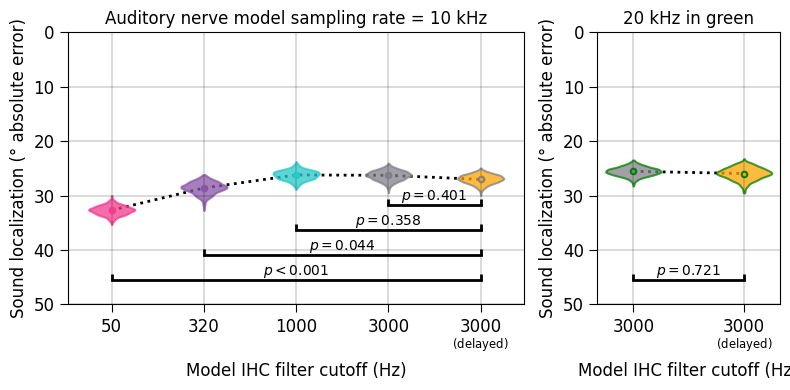

key_task=localization, key_metric='pearsonr'


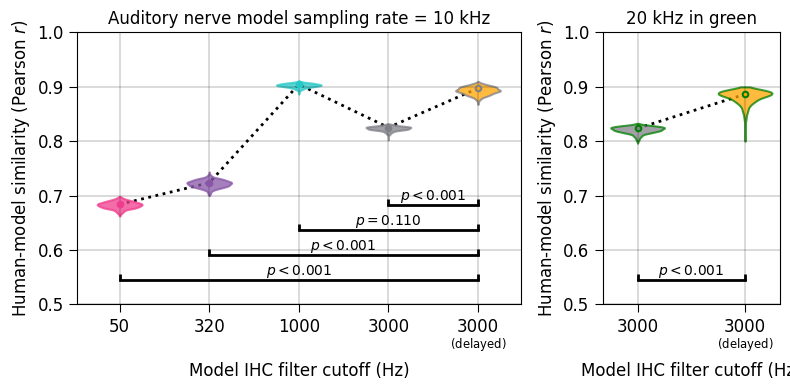

In [10]:
for key_metric in ["performance", "pearsonr"]:
    print(f"key_task=localization, {key_metric=}")
    fig, ax_arr = make_plot(
        list_list_model=[["50", "320", "1000", "3000", "3000_delayed"], ["sr20000_3000", "sr20000_3000_delayed"]],
        list_str_title=["Auditory nerve model sampling rate = 10 kHz", "20 kHz in green"],
        list_key_task="localization",
        list_key_metric=key_metric,
    )
    plt.tight_layout()
    plt.show()


key_task='spkr', key_metric='performance'


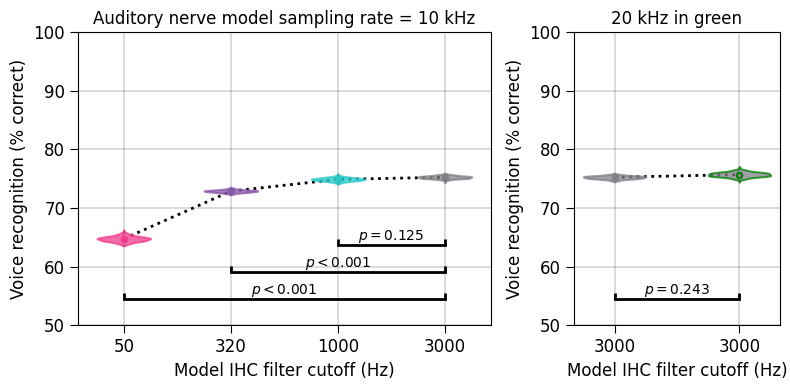

key_task='spkr', key_metric='pearsonr'


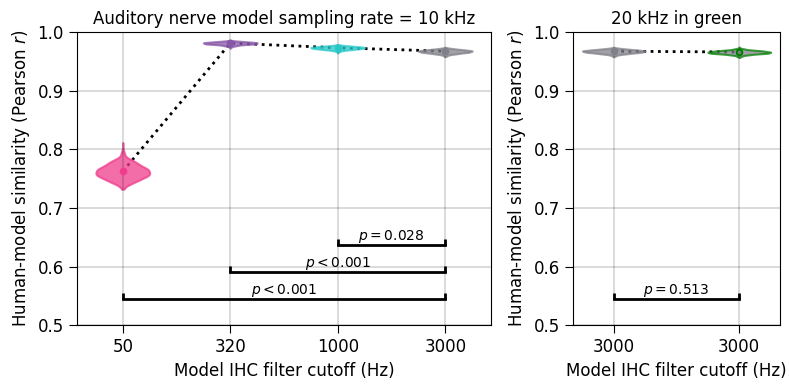

key_task='word', key_metric='performance'


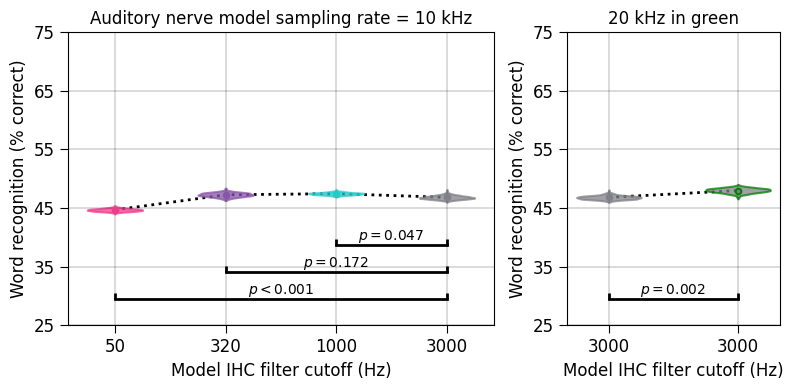

key_task='word', key_metric='pearsonr'


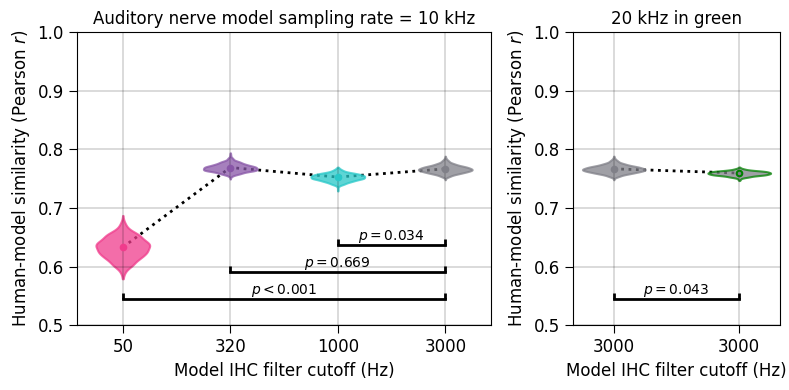

In [11]:
for key_task in ["spkr", "word"]:
    for key_metric in ["performance", "pearsonr"]:
        print(f"{key_task=}, {key_metric=}")
        fig, ax_arr = make_plot(
            list_list_model=[["50", "320", "1000", "3000"], ["3000", "sr20000_3000"]],
            list_str_title=["Auditory nerve model sampling rate = 10 kHz", "20 kHz in green"],
            list_key_task=key_task,
            list_key_metric=key_metric,
        )
        plt.tight_layout()
        plt.show()


key_task='spkr', key_metric='performance'


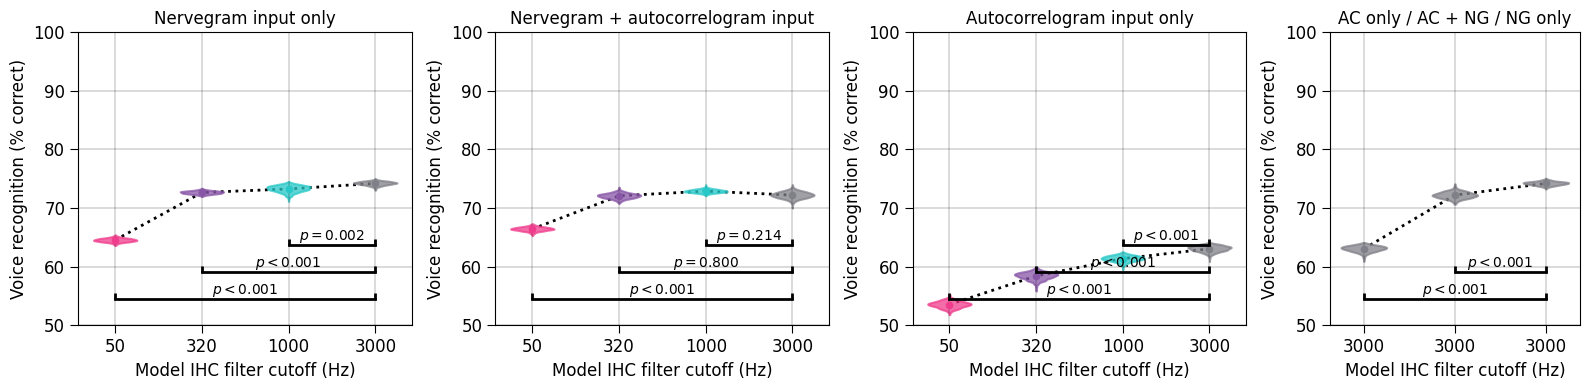

key_task='spkr', key_metric='pearsonr'


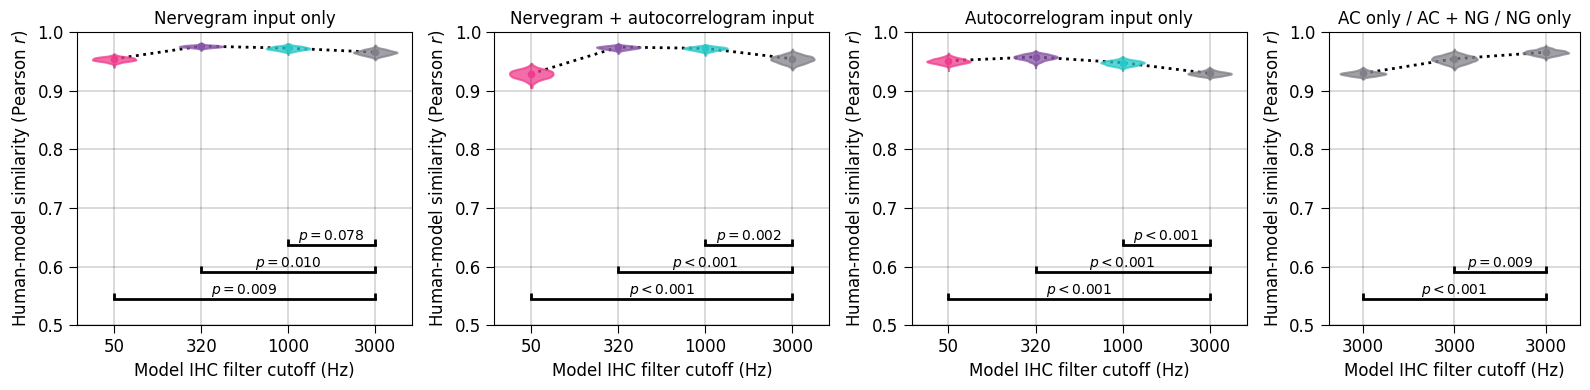

key_task='word', key_metric='performance'


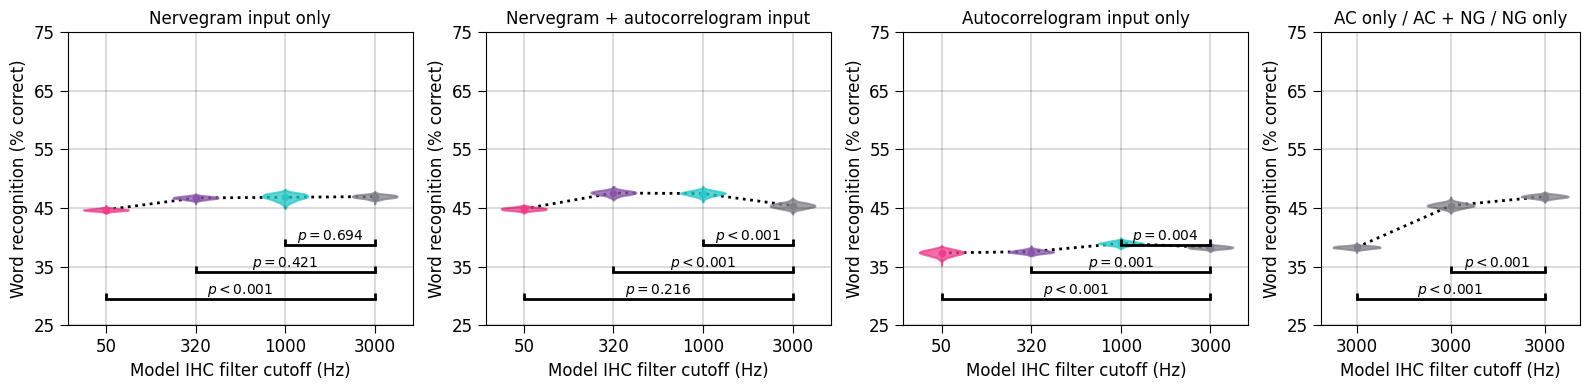

key_task='word', key_metric='pearsonr'


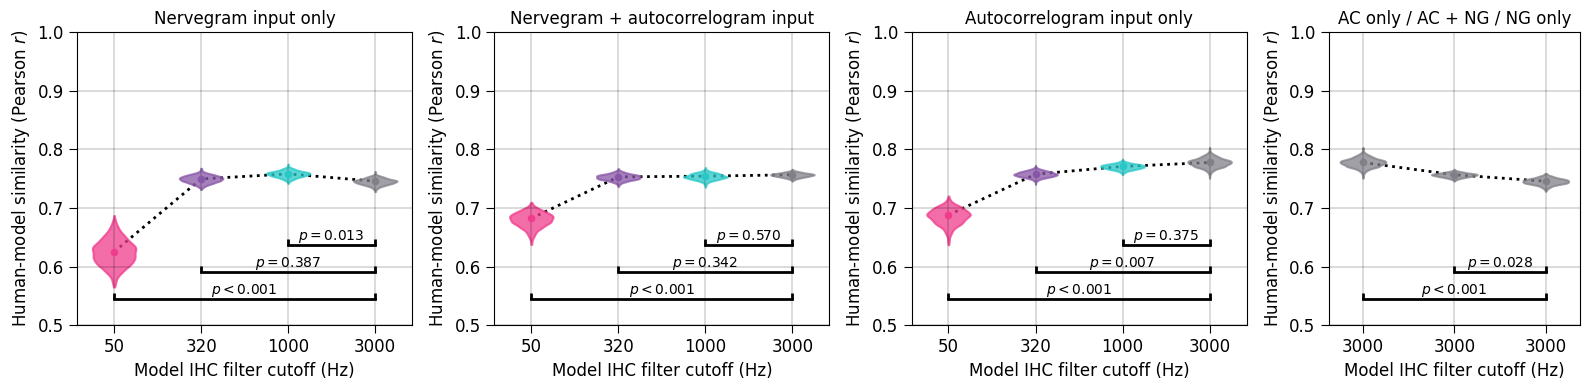

In [12]:
for key_task in ["spkr", "word"]:
    for key_metric in ["performance", "pearsonr"]:
        print(f"{key_task=}, {key_metric=}")
        fig, ax_arr = make_plot(
            list_list_model=[
                [
                    "50_simple",
                    "320_simple",
                    "1000_simple",
                    "3000_simple",
                ],
                [
                    "autocorr_concat_50",
                    "autocorr_concat_320",
                    "autocorr_concat_1000",
                    "autocorr_concat_3000",
                ],
                [
                    "autocorr_input_50",
                    "autocorr_input_320",
                    "autocorr_input_1000",
                    "autocorr_input_3000",
                ],
                [
                    "autocorr_input_3000",
                    "autocorr_concat_3000",
                    "3000_simple",
                ],
            ],
            list_str_title=["Nervegram input only", "Nervegram + autocorrelogram input", "Autocorrelogram input only", "AC only / AC + NG / NG only"],
            list_key_task=key_task,
            list_key_metric=key_metric,
        )
        plt.tight_layout()
        plt.show()
